#### Importing required libraries

In [18]:
import json
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split, Subset, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from torchtext.vocab import GloVe

In [19]:
with open('Laptop_Review_Train.json') as f:
    train_data = json.load(f)

In [20]:
with open('Laptop_Review_Val.json') as f:
    val_data = json.load(f)

In [21]:
with open('Laptop_Review_Test.json') as f:
    test_data = json.load(f)

#### BIO Encoding of data

In [22]:
def bio_label_encoding(tokens, aspects):
    labels = ['O'] * len(tokens)
    for aspect in aspects: 
        start = aspect['from']
        end = aspect['to']
        labels[start] = 'B'
        for i in range(start+1, end):
            labels[i] = 'I'
    return labels

#### Iterating over each sentence and encoding it 

In [23]:
def convert_to_bio(data):
    processed_data = {}
    for i in range(len(data)):
        words = data[i]['words']
        text = data[i]['raw_words']
        aspects = data[i]['aspects']
        labels = bio_label_encoding(words, aspects)
        processed_data[i] = {
            'text': text,
            'labels': labels
        }
    return processed_data

#### Preparing the data and saving it 

In [24]:
processed_train_data = convert_to_bio(train_data)
processed_val_data = convert_to_bio(val_data)
processed_test_data = convert_to_bio(test_data)

In [25]:
# dumping the processed data
with open('Laptop_Review_Train_Processed.json', 'w') as f:
    json.dump(processed_train_data, f, indent=4)
with open('Laptop_Review_Val_Processed.json', 'w') as f:
    json.dump(processed_val_data, f, indent=4)
with open('Laptop_Review_Test_Processed.json', 'w') as f:
    json.dump(processed_test_data, f, indent=4) 

#### Loading data

In [26]:
with open('Laptop_Review_Train_Processed.json') as f:
    train_data = json.load(f)
with open('Laptop_Review_Val_Processed.json') as f:
    val_data = json.load(f)
with open('Laptop_Review_Test_Processed.json') as f:
    test_data = json.load(f)

#### Preparing the data


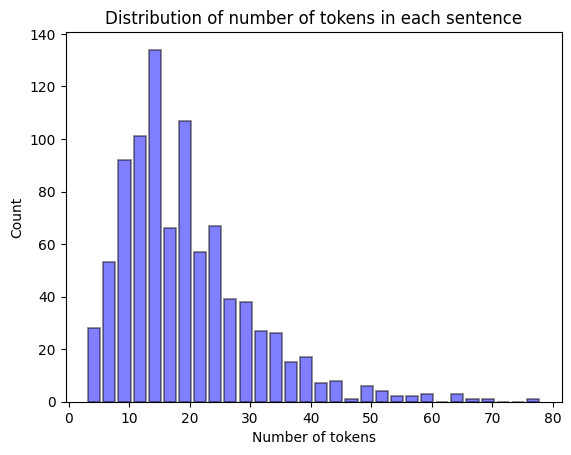

In [27]:
# plotting data distribution of number of tokens in each sentence
import matplotlib.pyplot as plt
label_counts = []
for key in train_data.keys():
    label_counts.append(len(train_data[key]['labels']))
plt.hist(label_counts, bins=30, alpha=0.5, color='b', edgecolor='black', linewidth=1.2, histtype='bar', align='mid', orientation='vertical', rwidth=0.8, label='Number of tokens')
plt.title('Distribution of number of tokens in each sentence')
plt.xlabel('Number of tokens')
plt.ylabel('Count')
plt.show()

In [28]:
train, val, test = [], [], []
for i in train_data:
    train.append([train_data[i]['text'], train_data[i]['labels']])
for i in val_data:
    val.append([val_data[i]['text'], val_data[i]['labels']])
for i in test_data:
    test.append([test_data[i]['text'], test_data[i]['labels']])

In [29]:
print(f'Training data size: {len(train)}')
print(f'Validation data size: {len(val)}')
print(f'Test data size: {len(test)}')

Training data size: 906
Validation data size: 219
Test data size: 328


In [30]:
for i in range(5):
    text, labels = train[i][0], train[i][1]
    print(f"Text: {text}\nLabels: {labels}\n")

Text: I charge it at night and skip taking the cord with me because of the good battery life .
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O']

Text: it is of high quality , has a killer GUI , is extremely stable , is highly expandable , is bundled with lots of very good applications , is easy to use , and is absolutely gorgeous .
Labels: ['O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O']

Text: Easy to start up and does not overheat as much as other laptops .
Labels: ['O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Text: Great laptop that offers many great features !
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'O']

Text: One night I turned the freaking thing off after using it , the next day I turn it on , no GUI , screen all dark , power light steady , hard drive ligh

In [31]:
data = train + val + test
# Finding number of unique words in the dataset
word_count = {}
for i in range(len(data)):
    words = data[i][0].split()
    for word in words:
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
print(f"Number of unique words in the dataset: {len(word_count)}")
print(f"Words and their counts: {list(word_count.items())[:5]}")

Number of unique words in the dataset: 3495
Words and their counts: [('I', 637), ('charge', 10), ('it', 499), ('at', 70), ('night', 5)]


In [32]:
word_list = list(word_count.keys())
# adding 'PAD' and 'UNK' to the word list
word_list.append('PAD')
word_list.append('UNK')
word_count['PAD'] = 0
word_count['UNK'] = 0
print(f"Number of unique words in the dataset after adding 'PAD' and 'UNK': {len(word_list)}")

Number of unique words in the dataset after adding 'PAD' and 'UNK': 3497


In [33]:
# Word-to-index and index-to-word mapping from the dataset
word_to_index = {word:idx for idx, word in enumerate(word_list)}
index_to_word = {idx:word for word, idx in word_to_index.items()}
label_to_idx = {'O': 0, 'B': 1, 'I': 2}
print(f"Word-to-index: {list(word_to_index.items())[:5]}")
print(f"Index-to-word: {list(index_to_word.items())[:5]}")

Word-to-index: [('I', 0), ('charge', 1), ('it', 2), ('at', 3), ('night', 4)]
Index-to-word: [(0, 'I'), (1, 'charge'), (2, 'it'), (3, 'at'), (4, 'night')]


In [10]:
glove_vectors = GloVe(name='6B', dim=300)
word_embeddings = np.zeros((len(word_list), 300))
for i in range(len(word_list)):
    word = word_list[i]
    idx = word_to_index[word]
    if word in glove_vectors.stoi:
        word_embeddings[idx] = glove_vectors[word]
    else:
        word_embeddings[idx] = glove_vectors['unk']
print(f"Shape of word_embeddings: {word_embeddings.shape}")

Shape of word_embeddings: (3497, 300)


In [11]:
# List of word vectors
word_vectors = [word_embeddings[word_to_index[word]] for word in word_list]
word_vectors = np.array(word_vectors)
print(f"Shape of word vectors: {word_vectors.shape}")

Shape of word vectors: (3497, 300)


#### Setting up DataLoaders

In [49]:
def collate_fn(batch):
    """
        Padding the sequences to the maximum length sequence in the batch
        Args:
            batch: list of individual elements of the dataset
        Returns:
            {'text' : padded_texts, 'labels' : padded_labels}
    """
    texts, labels = [item['text'] for item in batch], [item['labels'] for item in batch]
    max_len = max([len(text) for text in texts])
    padded_texts, padded_labels = [], []
    for i in range(len(texts)):
        text, label = texts[i], labels[i]
        # padding text and label sequences
        text = text + [word_to_index['PAD']] * (max_len - len(text))
        label = label + [label_to_idx['O']] * (max_len - len(label))
        padded_texts.append(text)
        padded_labels.append(label)
    return {'text': torch.tensor(padded_texts), 'labels': torch.tensor(padded_labels)}

In [46]:
class LaptopReviewDataset(Dataset):
    """
        Custom Dataset to load the Laptop Review dataset
        Args:
            data: list of tuples (text, labels)
            vocab_size: size of the vocabulary
            embedding_size: size of the word embeddings
            word_to_index: word-to-index mapping
            index_to_word: index-to-word mapping
            label_to_idx: label-to-index mapping
    """
    def __init__(self, data, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx):
        self.data = data
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.word_to_index = word_to_index
        self.index_to_word = index_to_word
        self.label_to_idx = label_to_idx 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text, labels = self.data[idx][0], self.data[idx][1]
        words = text.split()
        # converting words and labels to indices
        word_indices = [self.word_to_index[word] if word in self.word_to_index else self.word_to_index['UNK'] for word in words]
        label_indices = [self.label_to_idx[label] for label in labels]
        sample = {'text' : word_indices, 'labels' : label_indices}
        return sample

In [14]:
# constants
vocab_size = len(word_to_index)
embedding_size = 300

In [15]:
train_dataset = LaptopReviewDataset(train, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)
val_dataset = LaptopReviewDataset(val, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)
test_dataset = LaptopReviewDataset(test, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

In [18]:
for i, data in enumerate(train_dataloader, 0):
    print(f"Batch {i+1}\nText shape: {data['text'].size()}\nLabels shape: {data['labels'].size()}\n")
    for j in range(2):
        text = data['text'][j]
        labels = data['labels'][j]
        text_str = ' '.join([index_to_word[idx.item()] for idx in text])
        labels_str = ' '.join([list(label_to_idx.keys())[idx.item()] for idx in labels])
        print(f"Text: {text_str}\nLabels: {labels_str}\n")
    break

Batch 1
Text shape: torch.Size([32, 46])
Labels shape: torch.Size([32, 46])

Text: It has come into good use for my finances , scheduling , my parents business expenses , and it is definitely amazing for gaming . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
Labels: O O O O O B O O O O O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O O O O

Text: I love the way the entire suite of software works together . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
Labels: O O O O O O B I I O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O



### Task 2: RNN + GloVe

#### WandB Setup

In [21]:
import tqdm
import wandb   
wandb.login(relogin=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\prakh\.netrc


True

In [22]:
model_config = dict(
    task = 2, 
    model = 'RNN',
    embed_size = 300,
    embedding = 'GloVe',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [23]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

wandb: Currently logged in as: prakhar432 (nlp-assignments). Use `wandb login --relogin` to force relogin


#### Model Architecture

In [61]:
class RNNModel(nn.Module):
    """
        Model architecture to perform Sequence Labeling on the Laptop Review dataset. RNN, LSTM or GRU model is initialized based on the model configuration parameters.
        Args: 
            vocab_size: size of the vocabulary
            embed_size: size of the word embeddings
            hidden_size: size of the hidden state
            pretrained_embeddings: pre-trained word embeddings
            model_config: dictionary containing model configuration parameters
    """
    def __init__(self, vocab_size, embed_size, hidden_size, pretrained_embeddings, model_config):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings=pretrained_embeddings, freeze=True)
        self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden_size, num_layers=model_config['num_hidden'], nonlinearity=model_config['activation'], batch_first=True, dropout=model_config['dropout'])
        if (model_config['model'] == 'LSTM'):
            self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=model_config['num_hidden'], batch_first=True, dropout=model_config['dropout'])
        if (model_config['model'] == 'GRU'):
            self.rnn = nn.GRU(input_size=embed_size, hidden_size=hidden_size, num_layers=model_config['num_hidden'], batch_first=True, dropout=model_config['dropout'])
        self.fc = nn.Linear(hidden_size, 3)
        
    def forward(self, x):
        x = self.embedding(x)
        output, hidden = self.rnn(x)
        output = self.fc(output)
        return output, hidden

# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}\nHidden shape: {hidden.size()}\n")
    break

In [25]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Model Training and Evaluation

In [65]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            text, labels = data['text'], data['labels']
            output, hidden = model(text)
            output = output.view(-1, 3)
            labels = labels.view(-1)
            loss += criterion(output, labels).item()
            y_true += labels.tolist()
            y_pred += torch.argmax(output, 1).tolist()
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, macro_f1, loss

In [66]:
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config):
    wandb.define_metric('epoch')
    wandb.define_metric('minibatch_epoch')
    wandb.define_metric('train_loss', step_metric='epoch')
    wandb.define_metric('val_loss', step_metric='epoch')    
    wandb.define_metric('train_f1', step_metric='epoch')
    wandb.define_metric('val_f1', step_metric='epoch')
    wandb.define_metric('train_acc', step_metric='epoch')
    wandb.define_metric('val_acc', step_metric='epoch')
    wandb.define_metric('minibatch_loss', step_metric='minibatch_epoch')
    wandb.define_metric('minibatch_acc', step_metric='minibatch_epoch')
    wandb.define_metric('minibatch_f1', step_metric='minibatch_epoch')
    minibatch = 0
    for epoch in tqdm.tqdm(range(model_config['epochs'])):
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            text, labels = data['text'], data['labels']
            optimizer.zero_grad()
            outputs, hidden = model(text)
            outputs = outputs.view(-1, 3)
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            y_true = labels.tolist()
            y_pred = torch.argmax(outputs, 1).tolist()
            minibatch_acc = (np.array(y_true) == np.array(y_pred)).mean()
            minibatch_f1 = f1_score(y_true, y_pred, average='weighted')
            # logging
            log = {}
            log["minibatch_epoch"] = minibatch
            log["minibatch_loss"] = loss.item()
            log["minibatch_acc"] = minibatch_acc
            log["minibatch_f1"] = minibatch_f1
            wandb.log(log)
            minibatch += 1
        # logging
        accuracy, f1, loss = evaluate_model(model, train_dataloader, criterion)
        epoch_log = {}
        epoch_log["epoch"] = epoch
        epoch_log["train_loss"] = loss
        epoch_log["train_f1"] = f1
        epoch_log["train_acc"] = accuracy
        accuracy, f1, loss = evaluate_model(model, val_dataloader, criterion)
        epoch_log["val_loss"] = loss
        epoch_log["val_f1"] = f1
        epoch_log["val_acc"] = accuracy
        wandb.log(epoch_log)
    return model

In [28]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


In [83]:
def evaluation(model, dataloader, criterion):
    model.eval()
    loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            text, labels = data['text'], data['labels']
            outputs, hidden = model(text)
            outputs = outputs.view(-1, 3)
            labels = labels.view(-1)
            loss += criterion(outputs, labels).item()
            y_true += labels.tolist()
            y_pred += torch.argmax(outputs, 1).tolist()
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    precision = precision_score(y_true, y_pred, average='weighted')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    from sklearn.metrics import classification_report
    classification_report = classification_report(y_true, y_pred)
    return accuracy, precision, macro_f1, loss, classification_report

In [30]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

Test accuracy: 0.9653
Test precision: 0.9603
Test macro F1: 0.6546
Test loss: 2.5851

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     14774
           1       0.65      0.49      0.56       463
           2       0.63      0.32      0.42       243

    accuracy                           0.97     15480
   macro avg       0.75      0.60      0.65     15480
weighted avg       0.96      0.97      0.96     15480



In [31]:
wandb.finish()

Test accuracy,▁
Test loss,▁
Test macro F1,▁
Test precision,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_acc,▁▄▅▆▄▄▄▄▅▆▇▇▇▇▇▇▇▇████▇██▇███▇███▇██████
minibatch_epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_f1,▁▅▆▇▅▅▅▅▆▆█▇▇▇▇▇█▇██████████████████████
minibatch_loss,█▅▄▃▄▅▅▄▃▃▂▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇██▇███████████████████▇█
train_f1,▁▃▅▅▆▅▆▆▆▇▇▇▇███████████████████████████


In [32]:
# saving the model
torch.save(model.state_dict(), 'RNN_GloVe_Task2_Exp1.pth')

### Task 2: GRU + GloVe

#### WandB Setup

In [33]:
import tqdm
import wandb
wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\prakh\.netrc


True

In [34]:
model_config = dict(
    task = 2, 
    model = 'GRU',
    embed_size = 300,
    embedding = 'GloVe',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [35]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

#### Model Architecture


In [36]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}\nHidden shape: {hidden.size()}\n")
    break

3497 3497 300 128
Input shape: torch.Size([32, 50])
Label shape: torch.Size([32, 50])
Output shape: torch.Size([32, 50, 3])
Hidden shape: torch.Size([1, 32, 128])



C:\Users\prakh\AppData\Local\Temp\ipykernel_13344\532150329.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [37]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Model Training and Evaluation

In [38]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

100%|██████████| 100/100 [05:42<00:00,  3.42s/it]


In [39]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

Test accuracy: 0.9691
Test precision: 0.9649
Test macro F1: 0.6841
Test loss: 2.2265

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     14774
           1       0.70      0.52      0.60       463
           2       0.72      0.35      0.47       243

    accuracy                           0.97     15480
   macro avg       0.80      0.62      0.68     15480
weighted avg       0.96      0.97      0.97     15480



In [40]:
wandb.finish()

Test accuracy,▁
Test loss,▁
Test macro F1,▁
Test precision,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_acc,▁▁▆▅▁▄▅▅▆▇▇▆▇▇▇▇██▇█▇██▇▇▇█▇▇█▆███▇█▆▇██
minibatch_epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_f1,▁▂▆▆▃▅▆▆▇▇▇▇████████████▇▇████▇███▇█▇███
minibatch_loss,█▇▃▄▆▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▂▂▁▁
train_acc,▁▂▃▄▅▅▆▆▇▇▇█████████████████████████▇███
train_f1,▁▂▅▅▆▆▇▇▇▇██████████████████████████████


In [41]:
# saving the model
torch.save(model.state_dict(), 'GRU_GloVe_Task2_Exp1.pth')

### Task 2: LSTM + GloVe

#### WandB Setup

In [42]:
import tqdm
import wandb
wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\prakh\.netrc


True

In [43]:
model_config = dict(
    task = 2, 
    model = 'LSTM',
    embed_size = 300,
    embedding = 'GloVe',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [44]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

#### Model Architecture

In [46]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}")
    break

3497 3497 300 128
Input shape: torch.Size([32, 66])
Label shape: torch.Size([32, 66])
Output shape: torch.Size([32, 66, 3])


C:\Users\prakh\AppData\Local\Temp\ipykernel_13344\36252246.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [47]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Model Training and Evaluation

In [48]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

100%|██████████| 100/100 [08:05<00:00,  4.86s/it]


In [49]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

Test accuracy: 0.9651
Test precision: 0.9609
Test macro F1: 0.6636
Test loss: 2.5930

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     14774
           1       0.62      0.52      0.57       463
           2       0.65      0.33      0.44       243

    accuracy                           0.97     15480
   macro avg       0.75      0.61      0.66     15480
weighted avg       0.96      0.97      0.96     15480



In [50]:
wandb.finish()

Test accuracy,▁
Test loss,▁
Test macro F1,▁
Test precision,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_acc,▁▄▃▃▆▄▄▅▆▆▇▇▇█▇████▇▇█▇▇▇▇████▇██▇▇████▇
minibatch_epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_f1,▁▄▄▄▇▅▆▆▇▇▇█▇█▇████▇██████████████▇█████
minibatch_loss,█▄▅▅▂▄▄▃▂▂▂▂▂▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
train_acc,▁▁▂▄▄▅▅▅▆▇▇▇████████████████████████████
train_f1,▁▁▃▅▆▆▆▆▇▇██████████████████████████████


In [51]:
# saving the model
torch.save(model.state_dict(), 'LSTM_GloVe_Task2_Exp1.pth')

### Task 2: RNN + FastText

#### Preparing the data

In [45]:
train, val, test = [], [], []
for i in train_data:
    train.append([train_data[i]['text'], train_data[i]['labels']])
for i in val_data:
    val.append([val_data[i]['text'], val_data[i]['labels']])
for i in test_data:
    test.append([test_data[i]['text'], test_data[i]['labels']])

In [46]:
print(f'Training data size: {len(train)}')
print(f'Validation data size: {len(val)}')
print(f'Test data size: {len(test)}')

Training data size: 906
Validation data size: 219
Test data size: 328


In [47]:
for i in range(5):
    text, labels = train[i][0], train[i][1]
    print(f"Text: {text}\nLabels: {labels}\n")

Text: I charge it at night and skip taking the cord with me because of the good battery life .
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O']

Text: it is of high quality , has a killer GUI , is extremely stable , is highly expandable , is bundled with lots of very good applications , is easy to use , and is absolutely gorgeous .
Labels: ['O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O']

Text: Easy to start up and does not overheat as much as other laptops .
Labels: ['O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Text: Great laptop that offers many great features !
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'O']

Text: One night I turned the freaking thing off after using it , the next day I turn it on , no GUI , screen all dark , power light steady , hard drive ligh

In [48]:
data = train + val + test
# Finding number of unique words in the dataset
word_count = {}
for i in range(len(data)):
    words = data[i][0].split()
    for word in words:
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
print(f"Number of unique words in the dataset: {len(word_count)}")
print(f"Words and their counts: {list(word_count.items())[:5]}")

Number of unique words in the dataset: 3495
Words and their counts: [('I', 637), ('charge', 10), ('it', 499), ('at', 70), ('night', 5)]


In [49]:
word_list = list(word_count.keys())
# adding 'PAD' and 'UNK' to the word list
word_list.append('PAD')
word_list.append('UNK')
word_count['PAD'] = 0
word_count['UNK'] = 0
print(f"Number of unique words in the dataset after adding 'PAD' and 'UNK': {len(word_list)}")

Number of unique words in the dataset after adding 'PAD' and 'UNK': 3497


In [50]:
# Word-to-index and index-to-word mapping from the dataset
word_to_index = {word:idx for idx, word in enumerate(word_list)}
index_to_word = {idx:word for word, idx in word_to_index.items()}
label_to_idx = {'O': 0, 'B': 1, 'I': 2}
print(f"Word-to-index: {list(word_to_index.items())[:5]}")
print(f"Index-to-word: {list(index_to_word.items())[:5]}")

Word-to-index: [('I', 0), ('charge', 1), ('it', 2), ('at', 3), ('night', 4)]
Index-to-word: [(0, 'I'), (1, 'charge'), (2, 'it'), (3, 'at'), (4, 'night')]


In [51]:
from torchtext.vocab import FastText
fasttext_vectors = FastText(language="en")
word_embeddings = np.zeros((len(word_list), 300))
for i in range(len(word_list)):
    word = word_list[i]
    idx = word_to_index[word]
    if word in glove_vectors.stoi:
        word_embeddings[idx] = fasttext_vectors[word]
    else:
        word_embeddings[idx] = fasttext_vectors['unk']
print(f"Shape of word_embeddings: {word_embeddings.shape}")

Shape of word_embeddings: (3497, 300)


In [52]:
# List of word vectors
word_vectors = [word_embeddings[word_to_index[word]] for word in word_list]
word_vectors = np.array(word_vectors)
print(f"Shape of word vectors: {word_vectors.shape}")

Shape of word vectors: (3497, 300)


In [53]:
# constants
vocab_size = len(word_to_index)
embedding_size = 300

In [54]:
train_dataset = LaptopReviewDataset(train, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)
val_dataset = LaptopReviewDataset(val, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)
test_dataset = LaptopReviewDataset(test, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)

In [55]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

In [56]:
for i, data in enumerate(train_dataloader, 0):
    print(f"Batch {i+1}\nText shape: {data['text'].size()}\nLabels shape: {data['labels'].size()}\n")
    for j in range(2):
        text = data['text'][j]
        labels = data['labels'][j]
        text_str = ' '.join([index_to_word[idx.item()] for idx in text])
        labels_str = ' '.join([list(label_to_idx.keys())[idx.item()] for idx in labels])
        print(f"Text: {text_str}\nLabels: {labels_str}\n")
    break

Batch 1
Text shape: torch.Size([32, 59])
Labels shape: torch.Size([32, 59])

Text: We carry the netbook around here and there , hence it 's kinda of irritating when the LCD just `` slide '' downwards . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
Labels: O O O O O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

Text: The screen is framed by half- to a full-inch margin that is obviously unnecessary , reduces the screen size and increases the bulk . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
Labels: O B O O O O O O O O O O O O O O O B I O O O B O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O



In [57]:
import tqdm
import wandb   
wandb.login(relogin=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\prakh\.netrc


True

In [58]:
model_config = dict(
    task = 2, 
    model = 'RNN',
    embed_size = 300,
    embedding = 'FastText',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [59]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

wandb: Currently logged in as: prakhar432 (nlp-assignments). Use `wandb login --relogin` to force relogin


In [62]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}\nHidden shape: {hidden.size()}\n")
    break

3497 3497 300 128
Input shape: torch.Size([32, 50])
Label shape: torch.Size([32, 50])
Output shape: torch.Size([32, 50, 3])
Hidden shape: torch.Size([1, 32, 128])



C:\Users\prakh\AppData\Local\Temp\ipykernel_25772\532150329.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [63]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [68]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [04:12<00:00,  2.53s/it]


In [69]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

Test accuracy: 0.9640
Test precision: 0.9585
Test macro F1: 0.6402
Test loss: 2.4762

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14774
           1       0.63      0.48      0.54       463
           2       0.58      0.30      0.40       243

    accuracy                           0.96     15480
   macro avg       0.73      0.59      0.64     15480
weighted avg       0.96      0.96      0.96     15480



In [70]:
wandb.finish()

Test accuracy,▁
Test loss,▁
Test macro F1,▁
Test precision,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_acc,▁▃▅▆▄▂▄▆▅▆▆▇▇▆▇▇▇▇████▇▇▇▇█▇█▇▇▇█▆████▇█
minibatch_epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_f1,▁▄▆▆▅▄▅▆▆▆▇▇▇▇▇▇█▇████▇▇█▇█▇█████▇██████
minibatch_loss,█▄▃▃▄▅▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
train_acc,▁▁▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇████████▆█████████████
train_f1,▁▂▅▅▆▆▆▆▇▇▇▇▇▇████████████▇█████████████


In [71]:
# saving the model
torch.save(model.state_dict(), 'RNN_FastText_Task2_Exp1.pth')

### Task 2: GRU + FastText

In [72]:
import tqdm
import wandb
wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\prakh\.netrc


True

In [73]:
model_config = dict(
    task = 2, 
    model = 'GRU',
    embed_size = 300,
    embedding = 'FastText',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [74]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

In [75]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}\nHidden shape: {hidden.size()}\n")
    break

3497 3497 300 128
Input shape: torch.Size([32, 66])
Label shape: torch.Size([32, 66])
Output shape: torch.Size([32, 66, 3])
Hidden shape: torch.Size([1, 32, 128])



C:\Users\prakh\AppData\Local\Temp\ipykernel_25772\532150329.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [76]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [77]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

100%|██████████| 100/100 [08:34<00:00,  5.15s/it]


In [78]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

Test accuracy: 0.9686
Test precision: 0.9650
Test macro F1: 0.6925
Test loss: 2.3416

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     14774
           1       0.67      0.56      0.61       463
           2       0.71      0.37      0.48       243

    accuracy                           0.97     15480
   macro avg       0.79      0.64      0.69     15480
weighted avg       0.97      0.97      0.97     15480



In [79]:
wandb.finish()

Test accuracy,▁
Test loss,▁
Test macro F1,▁
Test precision,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_acc,▂▁▁▄▄▄▅▅▇▆▇▆▆▆▇▇▇▇▇█▇█▇▇▇▇▇█▇████▇█▇████
minibatch_epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_f1,▂▁▂▅▅▅▆▆▇▇▇▆▇▇▇▇▇█▇█▇█▇█▇▇██▇██████▇████
minibatch_loss,██▇▄▄▄▃▃▂▃▂▃▃▃▂▂▂▁▂▁▂▁▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁
train_acc,▁▁▃▃▄▄▅▅▅▆▆▆▇▇▇█████████████████████████
train_f1,▁▁▃▅▅▆▆▆▇▇▇▇████████████████████████████


In [80]:
# saving the model
torch.save(model.state_dict(), 'GRU_FastText_Task2_Exp1.pth')

### Task 2: LSTM + FastText

In [81]:
import tqdm
import wandb
wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\prakh\.netrc


True

In [82]:
model_config = dict(
    task = 2, 
    model = 'LSTM',
    embed_size = 300,
    embedding = 'FastText',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [83]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

In [84]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}")
    break

3497 3497 300 128
Input shape: torch.Size([32, 51])
Label shape: torch.Size([32, 51])
Output shape: torch.Size([32, 51, 3])


C:\Users\prakh\AppData\Local\Temp\ipykernel_25772\36252246.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [85]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [86]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

100%|██████████| 100/100 [06:55<00:00,  4.15s/it]


In [87]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

Test accuracy: 0.9670
Test precision: 0.9625
Test macro F1: 0.6696
Test loss: 2.5365

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     14774
           1       0.67      0.53      0.59       463
           2       0.64      0.33      0.43       243

    accuracy                           0.97     15480
   macro avg       0.76      0.62      0.67     15480
weighted avg       0.96      0.97      0.96     15480



In [88]:
wandb.finish()

Test accuracy,▁
Test loss,▁
Test macro F1,▁
Test precision,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_acc,▃▃▁▄▅▅▅▆▆▅▅▆▆▇▇▇▇█▇█▇▇████▇▇▇▇█████▇▇▇█▇
minibatch_epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_f1,▂▃▁▄▆▆▆▇▇▆▅▇▇▇▇▇▇█▇█▇██████▇▇▇█████▇█▇██
minibatch_loss,█▇▇▄▃▄▄▂▃▃▄▃▂▂▂▂▂▁▂▁▂▂▁▁▁▁▂▂▂▂▁▁▁▁▁▂▂▂▁▁
train_acc,▁▁▂▃▄▄▄▅▅▅▆▆▆▇▇▇▇███████████████████████
train_f1,▁▁▂▄▅▅▆▆▆▆▇▇▇▇██████████████████████████


In [ ]:
# saving the model
torch.save(model.state_dict(), 'LSTM_FastText_Task2_Exp1.pth')

### Task 2: RNN + Word2Vec

#### Preparing the data

In [63]:
train, val, test = [], [], []
for i in train_data:
    train.append([train_data[i]['text'], train_data[i]['labels']])
for i in val_data:
    val.append([val_data[i]['text'], val_data[i]['labels']])
for i in test_data:
    test.append([test_data[i]['text'], test_data[i]['labels']])

In [64]:
print(f'Training data size: {len(train)}')
print(f'Validation data size: {len(val)}')
print(f'Test data size: {len(test)}')

Training data size: 906
Validation data size: 219
Test data size: 328


In [65]:
for i in range(5):
    text, labels = train[i][0], train[i][1]
    print(f"Text: {text}\nLabels: {labels}\n")

Text: I charge it at night and skip taking the cord with me because of the good battery life .
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O']

Text: it is of high quality , has a killer GUI , is extremely stable , is highly expandable , is bundled with lots of very good applications , is easy to use , and is absolutely gorgeous .
Labels: ['O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O']

Text: Easy to start up and does not overheat as much as other laptops .
Labels: ['O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Text: Great laptop that offers many great features !
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'O']

Text: One night I turned the freaking thing off after using it , the next day I turn it on , no GUI , screen all dark , power light steady , hard drive ligh

In [66]:
data = train + val + test
# Finding number of unique words in the dataset
word_count = {}
for i in range(len(data)):
    words = data[i][0].split()
    for word in words:
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
print(f"Number of unique words in the dataset: {len(word_count)}")
print(f"Words and their counts: {list(word_count.items())[:5]}")

Number of unique words in the dataset: 3495
Words and their counts: [('I', 637), ('charge', 10), ('it', 499), ('at', 70), ('night', 5)]


In [67]:
word_list = list(word_count.keys())
# adding 'PAD' and 'UNK' to the word list
word_list.append('PAD')
word_list.append('UNK')
word_count['PAD'] = 0
word_count['UNK'] = 0
print(f"Number of unique words in the dataset after adding 'PAD' and 'UNK': {len(word_list)}")

Number of unique words in the dataset after adding 'PAD' and 'UNK': 3497


In [68]:
# Word-to-index and index-to-word mapping from the dataset
word_to_index = {word:idx for idx, word in enumerate(word_list)}
index_to_word = {idx:word for word, idx in word_to_index.items()}
label_to_idx = {'O': 0, 'B': 1, 'I': 2}
print(f"Word-to-index: {list(word_to_index.items())[:5]}")
print(f"Index-to-word: {list(index_to_word.items())[:5]}")

Word-to-index: [('I', 0), ('charge', 1), ('it', 2), ('at', 3), ('night', 4)]
Index-to-word: [(0, 'I'), (1, 'charge'), (2, 'it'), (3, 'at'), (4, 'night')]


In [70]:
import gensim
import torch
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

# Load word embeddings
word_embeddings = []
for word in word_list:
    try:
        word_embeddings.append(wv[word])
    except:
        word_embeddings.append(wv['unk'])
word_embeddings = np.array(word_embeddings)
print(f"Shape of word embeddings: {word_embeddings.shape}")


Shape of word embeddings: (3497, 300)


In [71]:
# List of word vectors
word_vectors = [word_embeddings[word_to_index[word]] for word in word_list]
word_vectors = np.array(word_vectors)
print(f"Shape of word vectors: {word_vectors.shape}")

Shape of word vectors: (3497, 300)


In [72]:
# constants
vocab_size = len(word_to_index)
embedding_size = 300

In [73]:
train_dataset = LaptopReviewDataset(train, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)
val_dataset = LaptopReviewDataset(val, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)
test_dataset = LaptopReviewDataset(test, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)

In [74]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

In [75]:
for i, data in enumerate(train_dataloader, 0):
    print(f"Batch {i+1}\nText shape: {data['text'].size()}\nLabels shape: {data['labels'].size()}\n")
    for j in range(2):
        text = data['text'][j]
        labels = data['labels'][j]
        text_str = ' '.join([index_to_word[idx.item()] for idx in text])
        labels_str = ' '.join([list(label_to_idx.keys())[idx.item()] for idx in labels])
        print(f"Text: {text_str}\nLabels: {labels_str}\n")
    break

Batch 1
Text shape: torch.Size([32, 40])
Labels shape: torch.Size([32, 40])

Text: It is VERY easy to type on and feels great - besides the added feature that the keyboard is lighted . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
Labels: O O O O O B O O O O O O O O B O O B O O O O O O O O O O O O O O O O O O O O O O

Text: It 's fast and has excellent battery life . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
Labels: O O O O O O B I O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O



In [76]:
import tqdm
import wandb   
wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\saras\.netrc


True

In [77]:
model_config = dict(
    task = 2, 
    model = 'RNN',
    embed_size = 300,
    embedding = 'Word2Vec',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [78]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

In [79]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}\nHidden shape: {hidden.size()}\n")
    break

3497 3497 300 128
Input shape: torch.Size([32, 78])
Label shape: torch.Size([32, 78])
Output shape: torch.Size([32, 78, 3])
Hidden shape: torch.Size([1, 32, 128])



In [80]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [81]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


In [84]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

Test accuracy: 0.9661
Test precision: 0.9633
Test macro F1: 0.6907
Test loss: 2.8735

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     14774
           1       0.62      0.58      0.60       463
           2       0.64      0.39      0.49       243

    accuracy                           0.97     15480
   macro avg       0.75      0.65      0.69     15480
weighted avg       0.96      0.97      0.96     15480



In [85]:
wandb.finish()

Test accuracy,▁
Test loss,▁
Test macro F1,▁
Test precision,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_acc,▂▁▅▃▄▃▅▆▅▆▇▇▇▆▇▇▇▇▇██████▇██▇███████████
minibatch_epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_f1,▁▁▅▅▄▄▆▆▆▇▇▇▇▆▇█▇███████████████████████
minibatch_loss,█▇▄▅▅▄▃▃▃▃▂▂▂▃▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▄▅▅▅▆▆▆▇▆▇▇▇█████████████▇███████████
train_f1,▁▂▅▅▆▆▆▇▇▇▇▇████████████████████████████


In [87]:
# saving the model
torch.save(model.state_dict(), 'RNN_Word2Vec_Task2_Exp1.pth')

#### Task 2: GRU + Word2Vec

In [88]:
import tqdm
import wandb
wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\saras\.netrc


True

In [89]:
model_config = dict(
    task = 2, 
    model = 'GRU',
    embed_size = 300,
    embedding = 'Word2Vec',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [90]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

In [91]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}\nHidden shape: {hidden.size()}\n")
    break

3497 3497 300 128
Input shape: torch.Size([32, 37])
Label shape: torch.Size([32, 37])
Output shape: torch.Size([32, 37, 3])
Hidden shape: torch.Size([1, 32, 128])



C:\Users\saras\AppData\Local\Temp\ipykernel_18036\532150329.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [92]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [93]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

100%|██████████| 100/100 [07:22<00:00,  4.42s/it]


In [94]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

Test accuracy: 0.9705
Test precision: 0.9680
Test macro F1: 0.7259
Test loss: 2.6822

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     14774
           1       0.70      0.64      0.67       463
           2       0.69      0.42      0.53       243

    accuracy                           0.97     15480
   macro avg       0.79      0.68      0.73     15480
weighted avg       0.97      0.97      0.97     15480



In [95]:
wandb.finish()

Test accuracy,▁
Test loss,▁
Test macro F1,▁
Test precision,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_acc,▁▅▁▅▅▄▅▆▆▆▅▇▇█▇█████████████████████████
minibatch_epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_f1,▁▅▃▆▆▅▆▆▇▇▆▇▇███████████████████████████
minibatch_loss,█▃▅▃▄▄▃▃▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▁▃▄▄▅▅▆▆▆▇▇▇███████████████████████████
train_f1,▁▁▄▅▆▆▇▇▇▇▇█████████████████████████████


In [96]:
# saving the model
torch.save(model.state_dict(), 'GRU_Word2Vec_Task2_Exp1.pth')

### Task 2: LSTM + Word2Vec

In [97]:
import tqdm
import wandb
wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: ERROR API key must be 40 characters long, yours was 81
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\saras\.netrc


True

In [98]:
model_config = dict(
    task = 2, 
    model = 'LSTM',
    embed_size = 300,
    embedding = 'Word2Vec',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [99]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

In [100]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}")
    break

3497 3497 300 128
Input shape: torch.Size([32, 56])
Label shape: torch.Size([32, 56])
Output shape: torch.Size([32, 56, 3])


C:\Users\saras\AppData\Local\Temp\ipykernel_18036\36252246.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [101]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [102]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

100%|██████████| 100/100 [05:39<00:00,  3.39s/it]


In [103]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

Test accuracy: 0.9702
Test precision: 0.9681
Test macro F1: 0.7210
Test loss: 2.3645

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     14774
           1       0.67      0.65      0.66       463
           2       0.71      0.40      0.51       243

    accuracy                           0.97     15480
   macro avg       0.79      0.68      0.72     15480
weighted avg       0.97      0.97      0.97     15480



In [104]:
wandb.finish()

Test accuracy,▁
Test loss,▁
Test macro F1,▁
Test precision,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_acc,▃▂▁▅▄▄▇▆▆▅▇▇█▇▇█▇███████████████████████
minibatch_epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_f1,▃▂▁▆▅▅▇▇▆▆▇██▇▇█████████████████████████
minibatch_loss,███▄▄▄▂▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▁▂▃▄▄▅▅▆▆▇▇▇█▇█████████████████████████
train_f1,▁▁▂▄▆▆▆▆▇▇▇▇████████████████████████████


In [105]:
# saving the model
torch.save(model.state_dict(), 'LSTM_Word2Vec_Task2_Exp1.pth')